In [1]:
from gensim.models import Word2Vec
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv('./data/train.txt')
test = pd.read_csv('./data/test.txt')
texts = list(train['text']) + list(test['text'])

In [3]:
train[:5]

,id,text,y
0,0,来扰乱天子的边防,0
1,1,崤山以东地区虽然混乱,0
2,2,秦昭王闻之 使人遗赵王书 愿以十五城请易璧,1
3,3,臣不胜受恩感激,1
4,4,现在如果把东西寄存在别人处,0


In [4]:
texts[0:10]

['来扰乱天子的边防',
 '崤山以东地区虽然混乱',
 '秦昭王闻之 使人遗赵王书 愿以十五城请易璧',
 '臣不胜受恩感激',
 '现在如果把东西寄存在别人处',
 '南北朝所以不治 文采胜质厚也',
 '而流贼进攻更急 城里有许多不同的意见',
 '吾上有三兄 皆不幸早世',
 '没有人不讲究熏衣剃面',
 '王曰 善']

In [5]:
# 训练向量
ndims = 50 #词向量维度
model = Word2Vec(sentences=texts, size=ndims, window=5)#词向量训练

sentences是训练样本，size是vector长度，window是窗口长度。每个词被表示成一个50维的向量

In [6]:
# '之'的词向量
print(model.wv['之'])

[ 3.1086391e-01 -7.9924040e-02 -2.0157899e-01  1.0492591e-02
  4.3148735e-01  2.1149510e-01 -3.1569634e-02 -9.8550518e-05
  5.1873779e-01  2.8804043e-01 -9.7279459e-02  3.3657601e-01
  1.2387726e-01 -8.9712940e-02  5.1590126e-02  7.4343860e-01
  3.8928455e-01  6.0298502e-01  1.1085374e-01 -3.2417268e-01
  8.9301074e-01  5.1745600e-01 -1.8437846e-01 -3.2719243e-02
  6.4264190e-01 -4.6355775e-01 -2.2568941e-01  4.5266545e-01
  2.5820649e-01 -6.9434589e-01  3.2954001e-01 -2.7558899e-01
 -3.9894700e-02 -4.0475720e-01 -4.9199441e-01 -6.5186864e-01
 -6.0817993e-01  8.6889088e-01  3.8828489e-01  4.0601927e-01
 -1.1791771e-01 -8.0803216e-02 -7.6900452e-01 -3.4983450e-01
 -5.0679076e-01 -3.6116105e-01 -5.0504404e-01 -4.5293799e-01
  2.4021594e-01 -2.6498601e-01]


In [7]:
# 和’之‘最接近的5个词
model.wv.most_similar('之', topn=5)

[('者', 0.996493399143219),
 ('曰', 0.9923252463340759),
 (' ', 0.9917057156562805),
 ('其', 0.9896804094314575),
 ('而', 0.987962007522583)]

In [8]:
# 计算两个词的相似度
model.similarity('东','南')

0.995756

In [9]:
# 训练模型保存
model.save('./model50')
# 模型加载
#model = word2vec.Word2Vec.load('./model50')

In [10]:
' ' in model

True

# 利用词向量进行数据可视化

## 可视化词向量

In [11]:
import numpy as np
# 使用keras + tensorboard 可视化

# word-index 对应关系
word2idx = {"_PAD": 0} # 初始化 `[word : token]` 字典，后期 tokenize 语料库就是用该词典。

# word--vector对应关系
vocab_list = [(k, model.wv[k]) for k, v in model.wv.vocab.items()]

# 存储所有 word2vec 中所有向量的数组，留意其中多一位，词向量全为 0， 用于 padding
# 存储词向量的数组，多出一行，shape: [len_words, len_vector]
embeddings_matrix = np.zeros((len(model.wv.vocab.items()) + 1, model.vector_size))
for i in range(len(vocab_list)):# 跳过空行
    word = vocab_list[i][0]# 词
    word2idx[word] = i + 1 # 存储词的index
    embeddings_matrix[i + 1] = vocab_list[i][1]#存储词的词向量

In [12]:
from keras.layers import Embedding
from keras.callbacks import TensorBoard
EMBEDDING_DIM = 50 #词向量维度

embedding_layer = Embedding(len(embeddings_matrix),
                            EMBEDDING_DIM,
                            weights=[embeddings_matrix],
                            trainable=False)

Using TensorFlow backend.


In [13]:
logdir = "./logs/{}".format('first')
tensorBoard = TensorBoard(log_dir = logdir,
                                    histogram_freq = 1,
                                    write_graph = True,
                                    write_images = False,
                                    embeddings_freq = 1,
                                    embeddings_layer_names = None,
                                    embeddings_metadata = None)


# self.model.fit(train_x, train_y,
#                        batch_size = self.batch_size,
#                        epochs = self.epochs,
#                        verbose = 1,
#                        callbacks = [tensorBoard])

In [14]:
mx = max([len(sen) for sen in texts])# 句子最大长度
print(mx)

38


In [15]:
# 定义网络进行分类
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np


## 处理文本
# 分词
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)# 训练，分词
sequences = tokenizer.texts_to_sequences(texts)# 根据学习内容，将文本转化成分词列表
print(sequences[:5])
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))#学习到的单词数
print(list(word_index)[:10])
# 将句子处理成相同长度 38
MAX_SEQUENCE_LENGTH = 38
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
# 处理标签
labels = to_categorical(np.asarray(train['y']))#变成二进制类别矩阵
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

[[652], [653], [654, 655, 656], [657], [658]]
Found 17100 unique tokens.
['窜梁鸿于海曲', '素誉之不立', '孔子', '天降吾民丰年', '而智术浅短', '详细地告诉了刘邦', '孔子编辑整合选择提炼', '其善者少', '然犹桀猾时起', '一千年出一位圣人']
Shape of data tensor: (8385, 38)
Shape of label tensor: (5000, 2)


In [17]:
# 数据集划分，训练集，验证集和测试集
N_Train = len(train)
X_train = data[: N_Train]
y_train = labels
X_test = data[N_Train:]
VALIDATION_SPLIT = 0.2

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2,random_state=42)

In [18]:
print("Shape of train:", X_train.shape)
print("Shape of validation:", X_val.shape)
print("Shape of test:", X_test.shape)

Shape of train: (4000, 38)
Shape of validation: (1000, 38)
Shape of test: (3385, 38)


In [19]:
# 处理Word2Vec Embedding层
import gensim

EMBEDDING_DIM = 50 #词向量维度
VECTOR_DIR = './model50'

# 从目录加载模型
w2v_model = gensim.models.Word2Vec.load(VECTOR_DIR)
# embedding_matrix矩阵用来初始化Embedding网络层权重
embedding_matrix = np.zeros((len(word_index)+1, EMBEDDING_DIM))

not_in_model, in_model = 0, 0
for word, i in word_index.items():
#     print(word, i)
    if word in w2v_model:
#         print(word)
        in_model += 1
        embedding_matrix[i] = np.asarray(w2v_model[word], dtype='float32')
    else:
        not_in_model += 1
print(str(not_in_model) + ' words not in model')
print(str(in_model) + ' words  in model')

16917 words not in model
183 words  in model


In [20]:
from keras.layers import Embedding
# Embedding层初始化
# 2D tensor with shape: (batch_size, sequence_length).
# 3D tensor with shape: (batch_size, sequence_length, output_dim).
embedding_layer = Embedding(len(word_index) + 1, # 输入行数据中index最大值 行数据用integer表示的数组
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,# 行大小
                            trainable=False)

In [21]:
# 模型定义 & 训练
from keras.layers import Dense, Input, Flatten, Dropout
from keras.layers import Conv1D, MaxPooling1D, Embedding, GlobalMaxPooling1D
from keras.models import Sequential
from keras.callbacks import TensorBoard

model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.2))
model.add(Conv1D(250, 3, padding='valid', activation='relu', strides=1))
model.add(MaxPooling1D(3))
model.add(Flatten())
model.add(Dense(EMBEDDING_DIM, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.summary()
#plot_model(model, to_file='model.png',show_shapes=True)

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])
print (model.metrics_names)

tbCallBack = TensorBoard(log_dir='./logs',  # log 目录
                 histogram_freq=0,  # 按照何等频率（epoch）来计算直方图，0为不计算
#                  batch_size=32,     # 用多大量的数据计算直方图
                 write_graph=True,  # 是否存储网络结构图
                 write_grads=True, # 是否可视化梯度直方图
                 write_images=True,# 是否可视化参数
                 embeddings_freq=0, 
                 embeddings_layer_names=None, 
                 embeddings_metadata=None)

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=2, batch_size=128,
         callbacks=[tbCallBack])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 38, 50)            855050    
_________________________________________________________________
dropout_1 (Dropout)          (None, 38, 50)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 36, 250)           37750     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 12, 250)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                150050    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 102       
Total para

In [22]:
print (model.evaluate(X_val, y_val))
submit = pd.read_csv('./data/sample_submit.csv')
submit['y'] = model.predict_proba(X_test)[:, 1]
submit.to_csv('cnn.csv', index=False)#保存， index=False，不添加序号

1000/1000 [==============================] - 0s 50us/step
[0.6799473829269409, 0.571]


In [23]:
from sklearn.metrics import log_loss

loss = log_loss(y_val, model.predict_proba(X_val)[:, 1])
print(loss)

0.6799473672686145


## 文本可视化

In [24]:
import numpy as np
ndim = 2
model2 = Word2Vec(sentences=texts, size=ndim, window=5)

total = len(train)
vecs = np.zeros([total, ndim])
print(vecs.shape)
for i, sentence in enumerate(train['text']):
    counts = 0 
    row = np.zeros((1,2))
    for word in sentence:
        try:
            if word != ' ':
                row += model2.wv[word]
                counts += 1
        except:
            pass
    if counts == 0:
        print(sentence)
    vecs[i, :] = row / counts

(5000, 2)


In [25]:
print(vecs.shape)
print(vecs[:10])

(5000, 2)
[[ 2.07815393 -0.84368237]
 [ 1.94510776 -0.69959279]
 [ 2.12628203 -1.2836191 ]
 [ 2.13879742 -0.54735452]
 [ 2.1492486  -1.20554032]
 [ 2.37434597 -0.41389458]
 [ 2.36662988 -0.87202247]
 [ 2.53149941 -0.53050218]
 [ 2.41880397 -0.51631431]
 [ 2.20754592 -1.47843985]]


vecs是一个句子向量，我们将句子向量可视化。

['blue', 'blue', 'red', 'red', 'blue', 'red', 'blue', 'red', 'blue', 'red']
Word2Vec: 白话文(蓝色)&文言文(红色)


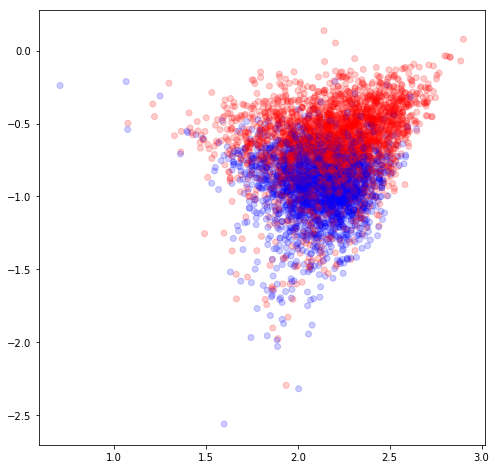

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(8,8))
#plt.axis([-3,1.5,1.5,3])
colors = list(map(lambda x : 'red' if x == 1 else 'blue', train['y']))
print(colors[:10])
plt.scatter(vecs[:, 0], vecs[:, 1], c=colors, alpha=0.2)
print("Word2Vec: 白话文(蓝色)&文言文(红色)")
#plt.show()

尽管只用了长度为2的向量，文言文（红色）和白话文（蓝色）已经可以较好区分。

## 建立分类器

In [27]:
from sklearn.tree import DecisionTreeClassifier
from gensim.models import Word2Vec
import numpy as np

train = pd.read_csv('./data/train.txt')
test = pd.read_csv('./data/test.txt')
submit = pd.read_csv('./data/sample_submit.csv')

In [28]:
train.head()

,id,text,y
0,0,来扰乱天子的边防,0
1,1,崤山以东地区虽然混乱,0
2,2,秦昭王闻之 使人遗赵王书 愿以十五城请易璧,1
3,3,臣不胜受恩感激,1
4,4,现在如果把东西寄存在别人处,0


In [29]:
submit.head()

,id,y
0,5000,0.5
1,5001,0.5
2,5002,0.5
3,5003,0.5
4,5004,0.5


In [30]:
test.head()

,id,text
0,5000,后来又合并为七个强国
1,5001,与吾父居者 今其室十无二三焉
2,5002,那么政局就会安定了
3,5003,我资米若薪于百姓 后之人必尔乎索之
4,5004,昔虞国宫之奇少长於君 君狎之


In [31]:
# word2vec重新训练
texts = list(train['text']) + list(test['text'])
n_train = len(train)
total = len(texts)
print(n_train, total)

5000 8385


In [32]:
n_dims = 50
#print(texts[:5])
model = Word2Vec(sentences=texts, size=n_dims)

# 获取数据的句子向量
sen_vecs = np.zeros([total, n_dims])

for i, sentence in enumerate(texts):
    counts, row = 0, 0
    for word in sentence:
        try:
            if word != ' ':# 获取句子向量,当前词不为空
                row += model.wv[word]
                counts += 1
        except:
            pass
    if counts == 0:# 空白句子
        print(sentence)
    # 平均化：去除句子长度的影响
    sen_vecs[i, :] = row / counts

In [33]:
# 使用决策树进行分类

clf = DecisionTreeClassifier(max_depth=3, random_state=1003)
# 使用训练集进行训练
clf.fit(sen_vecs[:n_train], train['y'])
print(clf.classes_)
# 获取为正类的概率，保存到文件中
submit['y'] = clf.predict_proba(sen_vecs[n_train:])[:, 1]
submit.to_csv('my_prediction.csv', index=False)#保存， index=False，不添加序号

[0 1]


In [34]:
import sys, os
from gensim.models import Word2Vec
import tensorflow as tf
import numpy as np
from tensorflow.contrib.tensorboard.plugins import projector

def visualize(model, output_path):
    meta_file = "w2x_metadata.tsv"
    placeholder = np.zeros((len(model.wv.index2word), 50))

    with open(os.path.join(output_path,meta_file), 'wb') as file_metadata:
        for i, word in enumerate(model.wv.index2word):
            placeholder[i] = model[word]
            # temporary solution for https://github.com/tensorflow/tensorflow/issues/9094
            if word == ' ':
                print("Emply Line, should replecaed by any thing else, or will cause a bug of tensorboard")
                file_metadata.write("{0}".format('<Empty Line>').encode('utf8') + b'\n')
            else:
                file_metadata.write("{0}".format(word).encode('utf8') + b'\n')

    # define the model without training
    sess = tf.InteractiveSession()

    embedding = tf.Variable(placeholder, trainable = False, name = 'w2x_metadata')
    tf.global_variables_initializer().run()

    saver = tf.train.Saver()
    writer = tf.summary.FileWriter(output_path, sess.graph)

    # adding into projector
    config = projector.ProjectorConfig()
    embed = config.embeddings.add()
    embed.tensor_name = 'w2x_metadata'
    embed.metadata_path = meta_file

    # Specify the width and height of a single thumbnail.
    projector.visualize_embeddings(writer, config)
    saver.save(sess, os.path.join(output_path,'w2x_metadata.ckpt'))
    print('Run `tensorboard --logdir={0}` to run visualize result on tensorboard'.format(output_path))

if __name__ == "__main__":
    model = Word2Vec.load("./model50")
    visualize(model,"./logs")

Emply Line, should replecaed by any thing else, or will cause a bug of tensorboard
Run `tensorboard --logdir=./logs` to run visualize result on tensorboard
